# Visual Question Answering (VQA)
The Framework is set up in way, that it is easy to combine a vision model from the [timm](https://github.com/huggingface/pytorch-image-models/tree/main/timm/models) library with a language model from [huggingface](https://huggingface.co/). For both models, either pre-trained weights can be used or the models can be trained as a composite in an end-to-end fashion.
For this example usage we will be using the [`RSVQAxBEN DataModule`](extra/rsvqaxben.ipynb) which loads the *RSVQAxBEN* dataset published by {cite:t}`rsvqaxben` inside a [`pytorch lightning`](https://pytorch-lightning.readthedocs.io/en/stable/) trainer. The network will be integrated into a [`LightningModule`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html).

First we start by importing the needed packages from `torch` and `pytorch_lightning` so that we can set up the `LightningModule`.

In [96]:
# remove-output
# import packages
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import optim

from configvlm import ConfigVLM

## Pytorch Lightning Module
The `Module` we use to encapsulate the model divides the usual loop into functions that are called internally by `pytorch_lightning`. The necessary functions are just
1. `training_step` and
2. `configure_optimizer`,

but to have a fully functional script, we add the validation and test steps as well as evaluation of the validation and test results. All `*_step` functions are working on a single batch while `*_epoch_end` functions are called after all batches are used and are passed a list of all return values of their respective `*_step` functions.
For Visual Question Answering (VQA) we have to add one additional function, as the network works with 3 values (vision + language input, output) instead of the usual 2 (input, output). Therefore we add a function (here called `_disassemble_batch`), which disassembles the batch into input and output where the _input contains both modalities_.

In [97]:
class LitVQAEncoder(pl.LightningModule):
    """
    Wrapper around a pytorch module, allowing this module to be used in automatic
    training with pytorch lightning.
    Among other things, the wrapper allows us to do automatic training and removes the
    need to manage data on different devices (e.g. GPU and CPU).
    """
    def __init__(
        self,
        config: ConfigVLM.VLMConfiguration,
        lr: float = 1e-3,
    ):
        super().__init__()
        self.lr = lr
        self.config = config
        self.model = ConfigVLM.ConfigVLM(config)

    def _disassemble_batch(self, batch):
        images, questions, labels = batch
        # transposing tensor, needed for Huggingface-Dataloader combination
        questions = torch.tensor(
            [x.tolist() for x in questions], device=self.device
        ).T.int()
        return (images, questions), labels

    def training_step(self, batch, batch_idx):
        x, y = self._disassemble_batch(batch)
        x_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(x_hat, y)
        self.log("train/loss", loss)
        return {"loss": loss}

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)
        return optimizer

    # ============== NON-MANDATORY-FUNCTION ===============

    def validation_step(self, batch, batch_idx):
        x, y = self._disassemble_batch(batch)
        x_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(x_hat, y)
        return {"loss": loss, "outputs": x_hat, "labels": y}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val/loss", avg_loss)

    def test_step(self, batch, batch_idx):
        x, y = self._disassemble_batch(batch)
        x_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(x_hat, y)
        return {"loss": loss, "outputs": x_hat, "labels": y}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("test/loss", avg_loss)

    def forward(self, batch):
        # because we are a wrapper, we call the inner function manually
        return self.model(batch)

## Configuring
Now that we have our model, we will use the `pytorch_lightning.Trainer` to run our loops. Results are logged to `tensorboard`.

We start by importing some callbacks used during training

In [98]:
from configvlm.ConfigVLM import VLMConfiguration, VLMType

as well as defining our hyperparameters.

In [99]:
vision_model_name = "resnet18"
text_model_name = "prajjwal1/bert-tiny"
seed = 42
number_of_channels = 12
image_size = 120
epochs = 4
lr = 5e-4

Then we create the configuration for usage in model creation later.

In [100]:
# remove-output
# seed for pytorch, numpy, python.random, Dataloader workers, spawned subprocesses
pl.seed_everything(seed, workers=True)

model_config = VLMConfiguration(
    timm_model_name=vision_model_name,
    hf_model_name=text_model_name,  # different to pre-training
    classes=1000,  # different to pre-training
    image_size=image_size,
    channels=number_of_channels,
    network_type=VLMType.VQA_CLASSIFICATION  # different to pre-training
)

Global seed set to 42


We log the hyperparameters and create a [Trainer](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html).

In [101]:
# remove-output
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    log_every_n_steps=1,
    logger=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Creating Model + Dataset
Finally, we create the model defined above and our datamodule. We will be using a datamodule from this framework described in the Extra section.

::: {note}
We get a user warning here that 'image_size' is not known as a keyword. This is expected as most Convolutional Neural Networks (CNNs) (just as the resnet here) operate independently of the image size of the input
:::

In [102]:
# remove-input
# remove-output
import pathlib
my_data_path = str(pathlib.Path("").resolve().parent.joinpath("configvlm").joinpath("extra").joinpath("mock_data").resolve(strict=True))
# set precision on Ampere cards to bfloat16
torch.set_float32_matmul_precision('medium')

In [103]:
from configvlm.extra.RSVQAxBEN_DataModule_LMDB_Encoder import RSVQAxBENDataModule
from configvlm.ConfigVLM import get_hf_model
model = LitVQAEncoder(config=model_config, lr=lr)
dm = RSVQAxBENDataModule(
    data_dir=my_data_path,  # path to dataset
    img_size=(number_of_channels, image_size, image_size),
    num_workers_dataloader=4,
    tokenizer = get_hf_model(model_name=text_model_name)[0]
)

/home/lhackel/Documents/development/ConfigVLM/configvlm/ConfigVLM.py:131: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(
Some weights of the model checkpoint at /home/lhackel/.cache/configvlm/pretrained_models/huggingface_models/prajjwal1/bert-tiny were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Dataloader using 4 workers

HINT: pin_memory set to None 


/home/lhackel/Documents/development/ConfigVLM/configvlm/ConfigVLM.py:115: UserWarning: Tokenizer was initialized pretrained
  warnings.warn("Tokenizer was initialized pretrained")


## Running
Now we just have to call the `fit()` and optionally the `test()` functions.

:::{note}
These calls generate quite a bit of output depending on the number of batches and epochs. The output is removed for readability.
:::

In [104]:
# remove-output
trainer.fit(model, datamodule=dm)

(17:56:43) Datamodule setup called
Loading split RSVQAxBEN data for train...
              25 QA-pairs indexed
              25 QA-pairs in reduced data set


Counting Answers: 100%|██████████| 25/25 [00:00<00:00, 351871.14it/s]



The 1000 most frequent answers cover about 100.00 % of the total answers.


Converting to NP arrays: 100%|██████████| 25/25 [00:00<00:00, 506558.45it/s]


Loading split RSVQAxBEN data for val...
              25 QA-pairs indexed
              25 QA-pairs in reduced data set


Converting to NP arrays: 100%|██████████| 25/25 [00:00<00:00, 765383.94it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | ConfigVLM | 16.6 M
------------------------------------
16.6 M    Trainable params
0         Non-trainable params
16.6 M    Total params
66.281    Total estimated model params size (MB)


setup took 0.01 seconds
  Total training samples:       25  Total validation samples:       25
Sanity Checking: 0it [00:00, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, loss=0.639]


In [105]:
# remove-output
trainer.test(model, datamodule=dm)

(17:56:47) Datamodule setup called
Loading split RSVQAxBEN data for test...
              25 QA-pairs indexed
              25 QA-pairs in reduced data set


Converting to NP arrays: 100%|██████████| 25/25 [00:00<00:00, 431512.76it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


setup took 0.00 seconds
  Total test samples:       25
Testing: 0it [00:00, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the envir

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    0.5322524309158325     │
└───────────────────────────┴───────────────────────────┘

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[{'test/loss': 0.5322524309158325}]

Here is an example forward call for the model. Since the input is normalized, the colors are slightly distorted. To display the image anyway, we select only the RGB channels and normalize this image to the range 0 to 1.
The input question is already returned by the dataset in the form of tokens, so we decode here again using the tokenizer. To make the input always the same size it may be padded.
Additionally only the first 10 elements of output + expected answer are shown, as the full lists have 1000 elements.

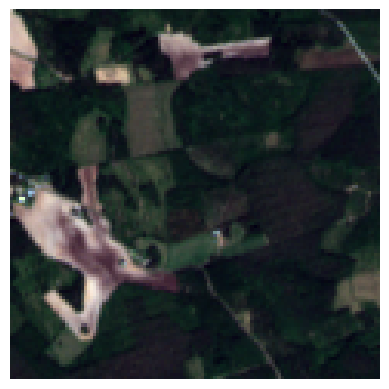

    Text: [CLS] are forests and heterogeneous agricultural areas present? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Question: [101, 2024, 6138, 1998, 21770, 10624, 6914, 14769, 4910, 2752, 2556, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Expected: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
          yes
    Real: [0.19753646850585938, -0.2776685953140259, -0.6270792484283447, -0.7901102900505066, -1.1356631517410278, -0.36914902925491333, 0.4346597492694855, -1.2643781900405884, -0.39748820662498474, -0.798112154006958]
          yes


In [106]:
# remove-input
import matplotlib.pyplot as plt

v, q, a = dm.val_ds[9]
# only choose BGR axis for display and bring into RGB order
# only needed for displaying
img_display = torch.flip(v[:3], [0])
img_display -= torch.min(img_display)
img_display /= torch.max(img_display)

_ = plt.imshow(img_display.permute(1, 2, 0))
plt.axis('off')
plt.show()

# add batch dimension
v_in = v.unsqueeze(0)
q_in = torch.tensor(q).unsqueeze(0)

# forward call, only use first result (batch size 1)
result = model((v_in, q_in))[0]

print(f"    Text: {dm.val_ds.tokenizer.decode(q)}")
print(f"Question: {q}")
print(f"Expected: {a.tolist()[:10]}")
print(f"          {dm.val_ds.selected_answers[a.argmax()]}")
print(f"    Real: {result.tolist()[:10]}")
print(f"          {dm.val_ds.selected_answers[a.argmax()]}")